M1. Actividad 
Salvador Rodríguez Paredes

Los agentes desarollados en la actividad son agentes reactivos con estados internos, lo cual nos quiere decir que estos mismos no son propositivos sino que se amoldan a sus circunstancias. Ellos no van a buscar la basura, la van a recoger solo en laso de haber caido en una celda con basura, no tienen conocimiento de la matriz en la que se encuentran y no comparten informacion de los vecinos que tienen con otros agentes, lo cual hace que el recoger la basura por completo sea una cuestion de azar o del tiempo maximo de ejecucion.

In [589]:
!pip install mesa

Defaulting to user installation because normal site-packages is not writeable


In [626]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation, RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [591]:
def vecinos(posicion, filas, columnas):
    fila, columna = posicion
    vecinos = []

    if fila > 0:
        vecinos.append((fila - 1, columna))

    if fila < filas - 1:
        vecinos.append((fila + 1, columna))

    if columna > 0:
        vecinos.append((fila, columna - 1))

    if columna < columnas - 1:
        vecinos.append((fila, columna + 1))

    if fila > 0 and columna > 0:
        vecinos.append((fila - 1, columna - 1))

    if fila > 0 and columna < columnas - 1:
        vecinos.append((fila - 1, columna + 1))

    if fila < filas - 1 and columna > 0:
        vecinos.append((fila + 1, columna - 1))

    if fila < filas - 1 and columna < columnas - 1:
        vecinos.append((fila + 1, columna + 1))

    return vecinos

In [611]:
class RobotAgent(Agent):
    def __init__(self, id, model, type=1):
        super().__init__(id, model)
        self.type = type
        self.i = {
            "cleaning" : False,
            "wait" : False
        }

    def see(self, e):
        neighbors = vecinos(e,WIDTH,HEIGHT)
        self.per = self.random.choice(neighbors)
        
        
    def next(self, i, per):
        cell_content = self.model.grid.get_cell_list_contents(per)
        if cell_content != []:
            for agent in cell_content:
                if isinstance(agent, TrashAgent):
                    i["cleaning"] = True
                elif isinstance(agent, RobotAgent):
                    i["wait"] = True
                    i["cleaning"] = False
         
    def action(self, i):
        if not i["cleaning"] and not i["wait"]:
            self.model.grid.move_agent(self, self.per)
        
        if i["cleaning"]:
            trash_agent = [trash for trash in self.model.grid.get_cell_list_contents(self.per) if isinstance(trash, TrashAgent)]
            trash_neighbours = [agent for agent in self.model.grid.get_neighbors(self.pos, moore=False, include_center=False) if isinstance(agent, TrashAgent)]
            for agent in trash_neighbours:
                if agent.pos == self.per:
                    self.model.schedule.remove(agent)
                    self.model.grid.remove_agent(agent)
                    self.model.grid.move_agent(self, self.per)      
                      
            i["cleaning"] = False;
        
        if not i["cleaning"] and i["wait"]:
            self.model.grid.move_agent(self, self.pos)    
            i["wait"] = False

    def step(self):
        self.see(self.pos)
        self.next(self.i, self.per)
        self.action(self.i)
        global steps
        steps = steps + 1

In [593]:
class TrashAgent(Agent):
    def __init__(self, id, model, type=2):
        super().__init__(id, model)
        self.per = None
        self.type = type
        
    def see(self, e):
        pass

    def next(self, i, per):
        pass

    def action(self, i):
        pass

    def step(self):
        pass

In [594]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for agent in model.schedule.agents:
        if isinstance(agent, RobotAgent):
            grid[agent.pos[0]][agent.pos[1]] = 2
        elif isinstance(agent, TrashAgent):
            grid[agent.pos[0]][agent.pos[1]] = 1
    return grid

In [609]:
steps = 0
class CleaningModel(Model):
    def __init__(self, width, height, num_agents, dirty):
        self.robot_agents = num_agents
        self.trash_agents = int(width * height * dirty)
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = SimultaneousActivation(self)
        self.total_steps = 0

        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        id = 0
        for i in range(self.robot_agents):
            agent = RobotAgent(id, self)
            self.grid.place_agent(agent, (1, 1))
            self.schedule.add(agent)
            id = id + 1

        for i in range(self.trash_agents):
            trash = TrashAgent(id, self)
            self.schedule.add(trash)
            empty_pos = list(self.grid.empties)
            if empty_pos:
                ran_pos = self.random.choice(empty_pos)
                self.grid.place_agent(trash, ran_pos)
            id = id + 1

    def step(self):
        trash_agent = [trash for trash in self.schedule.agents if isinstance(trash, TrashAgent)]
        if len(trash_agent) > 0:
            self.datacollector.collect(self)
            self.schedule.step()
            self.total_steps += 1
        else:
            self.running = False;
        


In [663]:
WIDTH = 10
HEIGHT = 10
AGENTS = 10
DIRT = 0.25
MAX_STEPS = 1000

start_time = time.time()
model = CleaningModel(WIDTH, HEIGHT, AGENTS, DIRT)
for i in range(MAX_STEPS):
    model.step()
    
finish_time = time.time() 


trash_agent = [trash for trash in model.schedule.agents if isinstance(trash, TrashAgent)]
robot_agent = [robot for robot in model.schedule.agents if isinstance(robot, RobotAgent)]


In [664]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

Tiempo de ejecución: 0:00:00.038191
Steps Maximos:  1000
Steps ocupados:  230
Robots:  10
Basura al final de la simulación:  0
Porcentaje de basura:  0.0 %


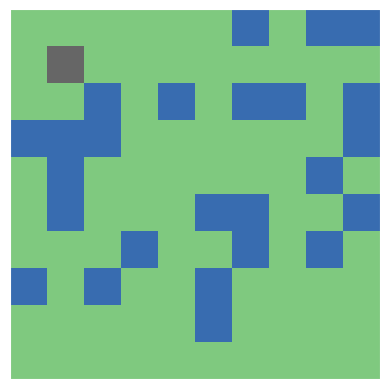

In [665]:
fig, axs = plt.subplots()
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap='Accent')


def animate(i):
    patch.set_data(all_grid.iloc[i][0])


anim = animation.FuncAnimation(fig, animate, frames=model.total_steps)

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(finish_time-start_time))))

print('Steps Maximos: ', str(MAX_STEPS))

print('Steps ocupados: ', str(model.total_steps))

print('Robots: ', str(len(robot_agent)))

print('Basura al final de la simulación: ', str(len(trash_agent)))

print('Porcentaje de basura: ', str(len(trash_agent)*100/(WIDTH*HEIGHT)),'%')


In [644]:
anim

Para el analisis del cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados estaremos tomando los siguientes valores como parametros:
Maximo de steps: 1000
Dimensiones del grid: 10x10
Porcentaje de basura 25%

Haciendo las pruebas con un solo agente robot pudimos notar que toma el maximo de steps y no logra dejar sin basura el grid, dejando 1% de basura en el grid, si duplicamos el numero de agentes conseguimos reducir el numero de steps usados casi a la mitad (506 steps en pruebas) y dejando el grid limpio, si volvemos a duplicar el numero reducimos el numero de steps usados para limpiar el grid a 423, duplicando una vez mas logramos 341 steps. El numero de steps se ha reducido pero no tan significativamente como la primera vez que duplicamos la cantidad de agentes, volvimos a encontrar un cambio significativo cuando duplicamos una vez mas el numero de agentes(16 robots) estos tomaron solo 109 steps.

Al ser un programa con agentes reactivos puedo asumir que no es hasta que el numero de agentes se aproximo al de celdas sucias que podemos notar que el tiempo de ejecucion se reduce. Una mejor implementacion se lograria si los agentes pudieran compartir su conocimiento y entender que hay al rededor de ellos para escocger a donde ir.